In [1]:
from tqdm import tqdm
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import cooler
import pandas as pd
import glob
import seaborn as sns
import matplotlib
import collections
from scipy.stats import wilcoxon

In [2]:
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [3]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)
sns.set(font='Helvetica')

In [4]:
chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17',
       'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']

In [22]:
   
def plot_cis_to_trans(array_lists, group1, group2, calculate_mean = True, vmax=1.45, savepath=None):

    if calculate_mean:
        map1 = np.median(np.array(array_lists[group1]), axis=0 )
        map2 = np.median(np.array(array_lists[group2]), axis=0 )
    else:
        
        map1 = np.array(array_lists[group1][list(array_lists[group1].keys())[0]])
        map2 = np.array(array_lists[group2][list(array_lists[group2].keys())[0]])
    
    m = map1[:-3, :-3] / map2[:-3, :-3]
    df_corr = pd.DataFrame(m)
    df_corr.index = chroms[:22]
    df_corr.columns = chroms[:22]
    df_corr.columns = [i.split("chr")[1] for i in df_corr.columns.tolist()]
    df_corr.index =  df_corr.columns.tolist()    

    g = sns.clustermap(df_corr,  
                       figsize = (6.5,6.5),
                       cbar_kws={"orientation": "horizontal"},
                       metric="correlation", cmap="RdBu_r",vmax = vmax, vmin = 1-(vmax-1))
    x0, _y0, _w, _h = g.cbar_pos
    g.tick_params(axis='x', labelsize=13)
    g.tick_params(axis='y', labelsize=13)
    
    g.ax_cbar.set_position([x0+0.183, 1.11, g.ax_row_dendrogram.get_position().width+0.555, 0.02])    
    g.fig.suptitle(f"{group1} / {group2}" + '; average=%.3f' % np.nanmean(m), fontsize=16,  y=1.02, x =0.58)    
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=1)    
    sns.set_style("ticks")    
    g.ax_row_dendrogram.set_visible(True)
    g.ax_col_dendrogram.set_visible(True)
    g.cax.yaxis.set_ticks_position("default")   
    if savepath:
        plt.savefig(savepath, dpi=400, bbox_inches='tight', format='pdf')
    plt.show()
    
def compute_cis_trans(hiclist, dropdiag=0, resolution=50000, stable=True, normalized=False):
    interchrom = {}
    for path in tqdm(hiclist):
        print(path)
        clr = cooler.Cooler(path + '::/resolutions/%d' % resolution)
        sizes = np.array(clr.chromsizes.values) / resolution
        norm = np.outer(sizes, sizes)
        pix = clr.pixels()[:]
        pix_no_diag = pix[pix.bin2_id >= pix.bin1_id + dropdiag] #delete m first diagonals
        bins = clr.bins()[:].drop(labels=['start', 'end'], axis=1)

        cis_trans = np.asarray(
                    pix_no_diag.merge(bins, left_on='bin1_id', right_index=True).\
                                merge(bins, left_on='bin2_id', right_index=True).\
                                groupby(['chrom_x', 'chrom_y']).sum().\
                                unstack(fill_value=0)['count']) #convert to square matrix

        cis_trans = cis_trans + cis_trans.T - np.diag(np.diag(cis_trans))
        if normalized:
            fullsum = np.nansum(cis_trans)
            if fullsum == 0.:
                print('Drop %s due to zero contact sum' % path)
                continue
            cis_trans = cis_trans / fullsum * 2 * 1_000_000 #scale by constant
        if stable:
            cis_trans += 1
        result = cis_trans / norm
        interchrom[os.path.splitext(os.path.basename(clr.filename))[0]] = result 
    return interchrom

In [6]:
def plot_cis_to_trans_any_maps(map1, map2, name, vmax=1.45, savepath=None):    
    m = map1[:-3, :-3] / map2[:-3, :-3]
    df_corr = pd.DataFrame(m)
    df_corr.index = chroms[:22]
    df_corr.columns = chroms[:22]
    df_corr.columns = [i.split("chr")[1] for i in df_corr.columns.tolist()]
    df_corr.index =  df_corr.columns.tolist()    
 
    g = sns.clustermap(df_corr,  
                       figsize = (7,7), 
                       cbar_kws={"orientation": "horizontal"},
                       metric="correlation", cmap="RdBu_r",vmax = vmax, vmin = 1-(vmax-1))
    x0, _y0, _w, _h = g.cbar_pos
    g.tick_params(axis='x', labelsize=13)
    g.tick_params(axis='y', labelsize=13)
    
    g.ax_cbar.set_position([x0+0.183, 1.11, g.ax_row_dendrogram.get_position().width+0.555, 0.02])    
    g.fig.suptitle(f"{name}" + '; average=%.3f' % np.nanmean(m), fontsize=16,  y=1.02, x =0.58)    
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=1)    
    sns.set_style("ticks")    
    g.ax_row_dendrogram.set_visible(True)
    g.ax_col_dendrogram.set_visible(True)
    g.cax.yaxis.set_ticks_position("default")   
    if savepath:
        plt.savefig(savepath, dpi=400, bbox_inches='tight', format='pdf')
    plt.show()
    
def calculate_cis_trans_several_files(files, directory, normalized=False):
    types = [i.split('_')[1].split('-')[1].split("minus")[0] for i in files]
    types = [i for i in types if 'plus' not in i] #["2M", "318", "3M", "91"]
    res_cis_to_trans = {}
    for type in types:
        files_pair = [directory+"/"+file for file in files if type in file]
        print(type)
        res_cis_to_trans[type] = {}
        res_cis_to_trans[type] = compute_cis_trans(files_pair, dropdiag=0, resolution=50000, stable=True, normalized=normalized) 
    return res_cis_to_trans, types

In [7]:
#set path to the individual sampled maps
path_to_maps = "/tank/projects/diana_hic/cultures_vs_postmortem/0_prepare_maps/merged_by_groups/"
files = [file for file in os.listdir(path_to_maps) if "mcool" in file]
files.sort()
files

['developing_4samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 'ipcs_derived_neurons_8samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 'post_mortem_6samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 'stem_cells_4samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool']

In [4]:
samples = ['developing', 'ipcs_derived_neurons',
       'post_mortem', 'stem_cells']

groups = ['Developing', 'iPSC-derived',           
          'Post-mortem', 'Stem cells']
assert len(groups) == len(samples) 
samples2groups = {i:k for i,k in zip(samples, groups)}

In [12]:
groups_results = {}
selected_samples =[]
for group in tqdm(set(groups)):
    print(group)
    selected_samples = [i for i,k in samples2groups.items() if k == group]
    hiclist = [path_to_maps+i for i in files if any(e in i for e in selected_samples) ]
    cis_to_trans= compute_cis_trans(hiclist, normalized=True) #NORMALIZED
    groups_results[group] = cis_to_trans
    print('__'*7)

with open('/tank/projects/diana_hic/cultures_vs_postmortem/3_general_chromatin_anlysis/general_chromatin_analysis_resutls/main_files/cis_to_trans_updated090824.p', 'wb') as fp:
    pickle.dump(groups_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

Developing



  0%|                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

/tank/projects/diana_hic/cultures_vs_postmortem/0_prepare_maps/merged_by_groups/developing_4samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool



 25%|███████████████████████████████████▎                                                                                                         | 1/4 [30:56<1:32:48, 1856.26s/it]

______________
Post-mortem



  0%|                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

/tank/projects/diana_hic/cultures_vs_postmortem/0_prepare_maps/merged_by_groups/post_mortem_6samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool



 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 2/4 [54:08<52:46, 1583.47s/it]

______________
Stem cells



  0%|                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

/tank/projects/diana_hic/cultures_vs_postmortem/0_prepare_maps/merged_by_groups/stem_cells_4samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3/4 [1:02:39<18:13, 1093.53s/it]

______________
iPSC-derived



  0%|                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

/tank/projects/diana_hic/cultures_vs_postmortem/0_prepare_maps/merged_by_groups/ipcs_derived_neurons_8samples_5kb.drop_diag.5kb.mcool.sampled_exact.mcool



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [1:25:33<00:00, 1283.36s/it]

______________


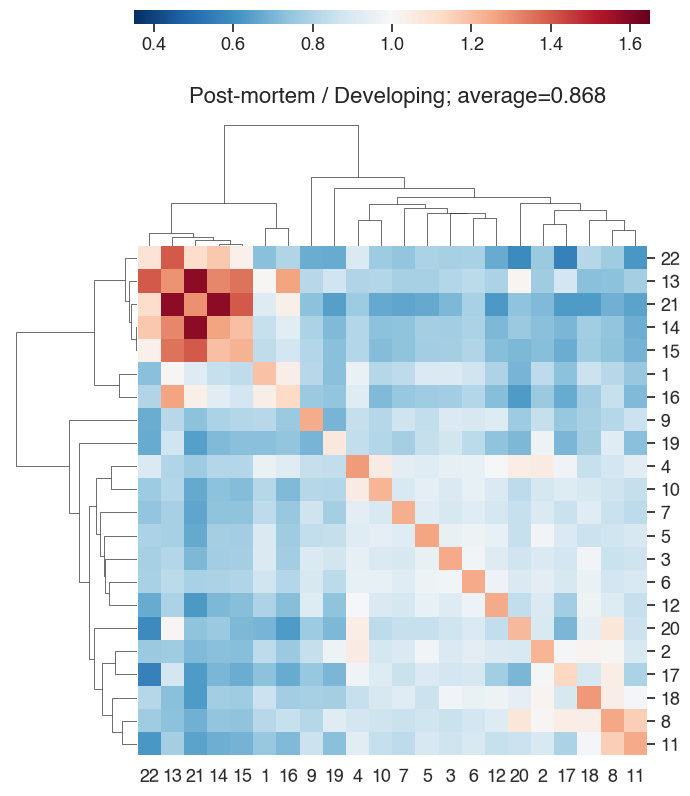

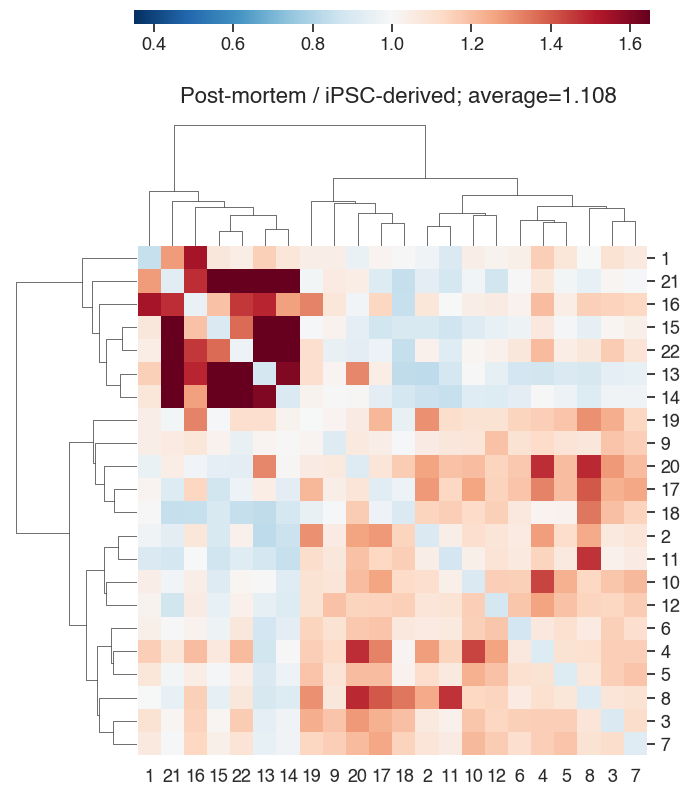

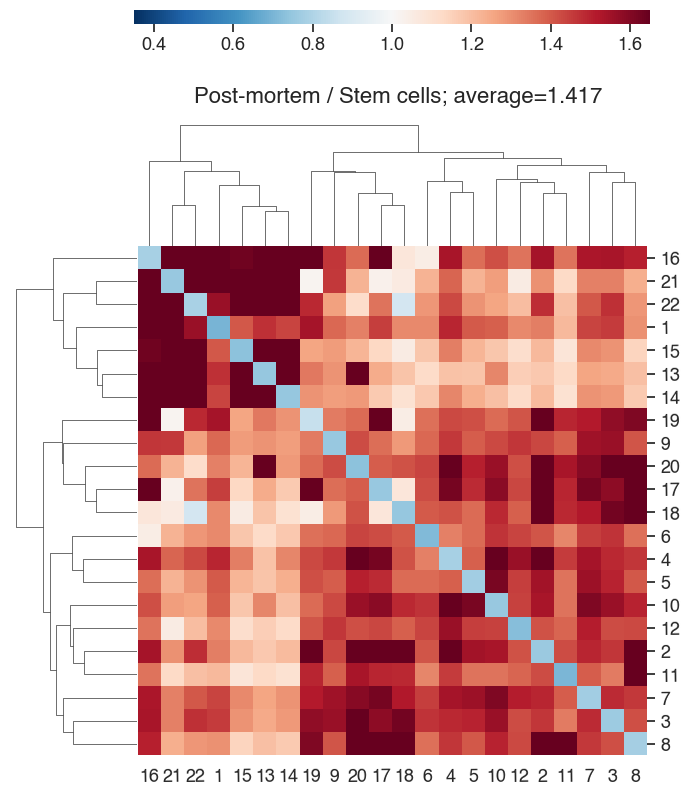

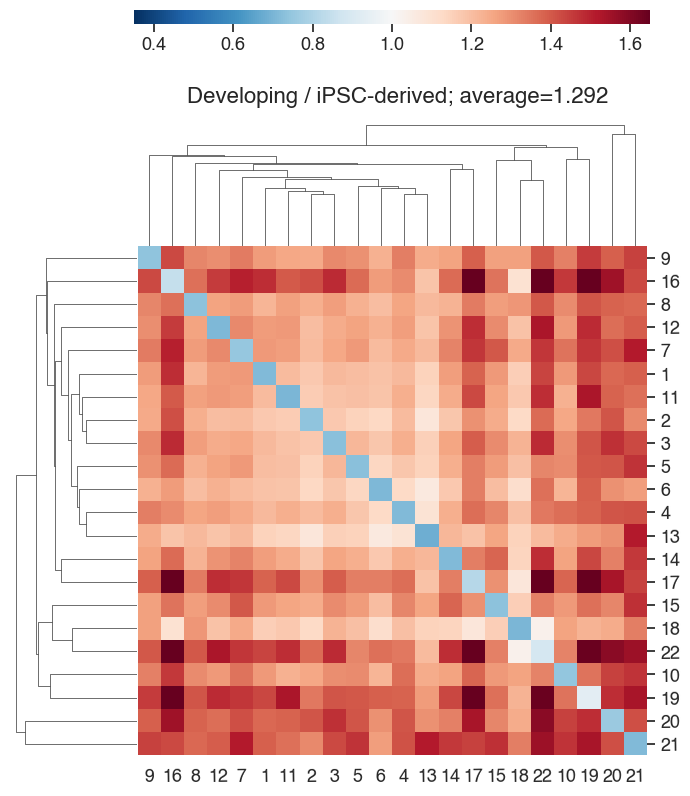

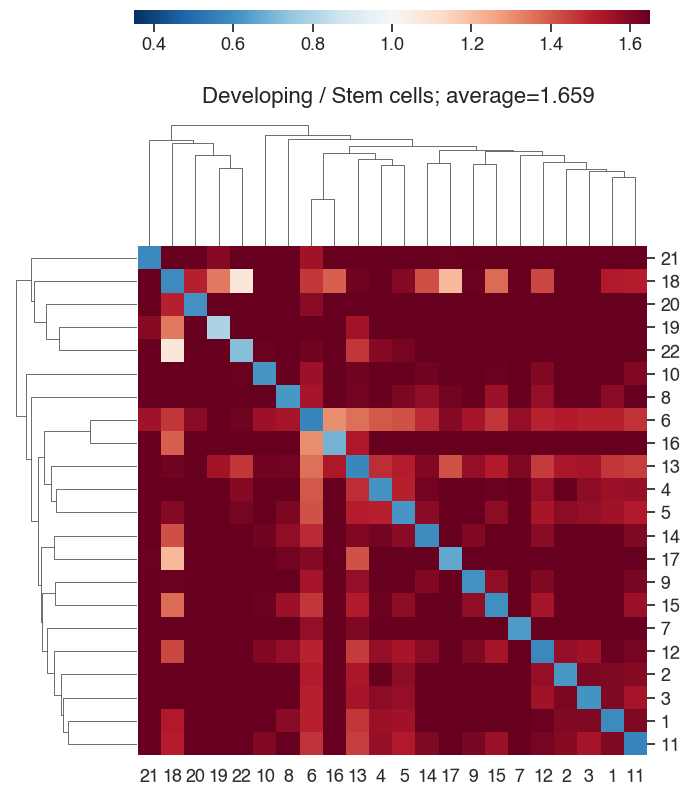

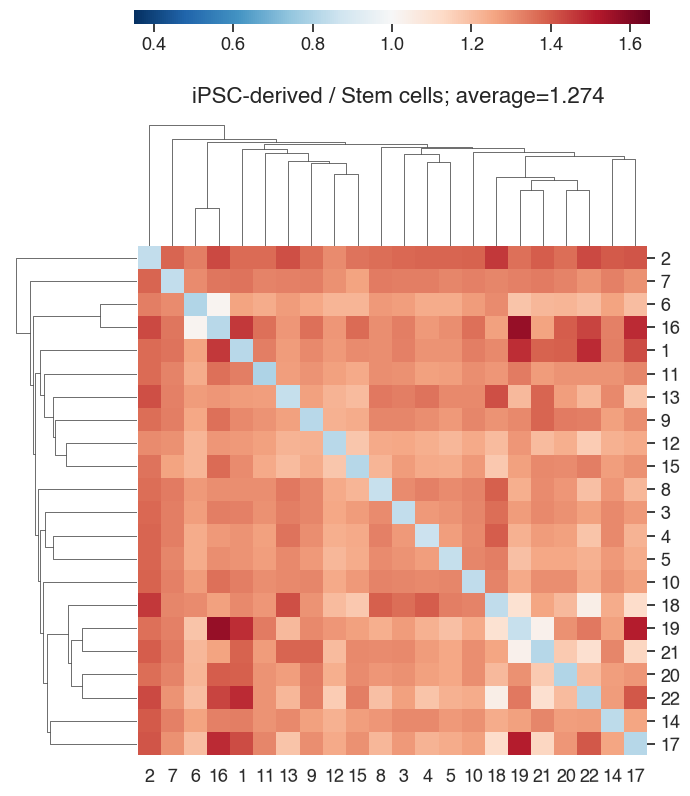

In [42]:
groups_pairs = [['Post-mortem','Developing'  ], 
               ['Post-mortem', 'iPSC-derived'],
               ['Post-mortem', 'Stem cells'],
               ['Developing', 'iPSC-derived'],
               ['Developing', 'Stem cells'],
                ['iPSC-derived', 'Stem cells']]
vmaxes = [1.65, 3, 3,3,3]
for group1, group2 in groups_pairs:
    plot_cis_to_trans(groups_results, group1, group2, calculate_mean=False, vmax=1.65, savepath=None)

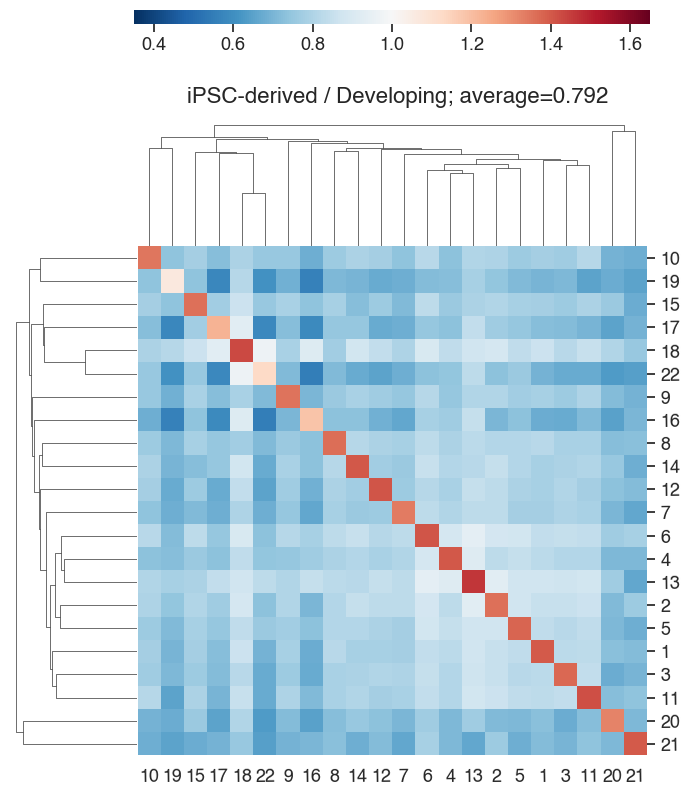

In [35]:
group1 = 'iPSC-derived'
group2 = 'Developing'
plot_cis_to_trans(groups_results, group1, group2, calculate_mean=False, vmax=1.65, savepath=None)

['developing_4samples_5kb.drop_diag.5kb.mcool.sampled_exact']

# 1. Prepare data

In [8]:
chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17',
       'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']

In [9]:
path_to_maps = os.getenv('PATH_TO_MAPS')
files = [file for file in os.listdir(path_to_maps) if "mcool" in file]
files.sort()
files

['Ballerino2022_NES_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 'Ballerino2022_NPC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 'Ballerino2022_iPSC_NeuNplus.sampled_exact.mcool',
 'Heffel_2T.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool',
 'Heffel_3T.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool',
 'Heffel_adult.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool',
 'Heffel_infant.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool',
 'Hu2021_NeuNplus.sampled_exact.mcool',
 'Li2022_iPSC_NeuNplus.sampled_exact.mcool',
 'Lu2020_iPSC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 'Lu2020_iPSC_NeuNplus.sampled_exact.mcool',
 'Our_data_iPSC_NeuNplus.drop_diag.5kb.mcool.sampled_exact.mcool',
 'Pletenev2024_NeuNplus.sampled_exact.mcool',
 'Rahman2023_FetalBrain.drop_diag.5kb.mcool.sampled_exact.mcool',
 'Rahman2023_NeuNplus.sampled_exact.mcool',
 'Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI.sampled_exact.mcool',
 'Rajarajan_NPC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool',
 

In [12]:
path_to_mapping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')
mapping = pd.read_feather(f'{path_to_mapping}/main_files_mapping.feather')
mapping.head()

,sample_map,Group,Simple_Name,sample,sample_init
0,Ballerino2022_NES_5kb.drop_diag.5kb.mcool.samp...,Stem-like cells,NES Ballerino,Ballerino2022_NES_Stem cells,Ballerino2022_NES
1,Ballerino2022_NPC_5kb.drop_diag.5kb.mcool.samp...,Stem-like cells,NPC Ballerino,Ballerino2022_NPC_Stem cells,Ballerino2022_NPC
2,Ballerino2022_iPSC_NeuNplus.sampled_exact.mcool,iPSC-derived neurons,Ballerino,Ballerino2022_iPSC_NeuNplus_iPSC-derived,Ballerino2022_iPSC_NeuNplus
3,Heffel_2T.3056_cells.5kb.drop_diag.5kb.sampled...,Fetal neurons,Heffel (2T),Heffel_2T_Developing,Heffel_2T
4,Heffel_3T.3056_cells.5kb.drop_diag.5kb.sampled...,Fetal neurons,Heffel (3T),Heffel_3T_Developing,Heffel_3T



# 2. Calculate cis to trans contact ratio

In [15]:
samples2groups = dict(mapping[['sample_init', 'Group']].values)
c = collections.Counter(list(samples2groups.values()))
print(c)

Counter({'iPSC-derived neurons': 7, 'Post-mortem neurons': 5, 'Stem-like cells': 4, 'Fetal neurons': 4})


In [17]:
groups_results = {}
selected_samples =[]
for group in tqdm(set(list(samples2groups.values()))):
    selected_samples = [i for i,k in samples2groups.items() if k == group]
    hiclist = [path_to_maps+i for i in files if any(e in i for e in selected_samples) ]
    cis_to_trans= compute_cis_trans(hiclist, normalized=True) #NORMALIZED
    groups_results[group] = cis_to_trans

with open('./cis_to_trans_data/cis_to_trans_dara.pt', 'wb') as fp:
    pickle.dump(groups_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('./cis_to_trans_data/cis_to_trans_dara.pt', 'rb') as handle:
    groups_results = pickle.load(handle)

In [20]:
groups = set(list(samples2groups.values()))
set(groups)

{'Fetal neurons',
 'Post-mortem neurons',
 'Stem-like cells',
 'iPSC-derived neurons'}

In [21]:
array_lists = {}
for group in tqdm(set(groups)):
    array_lists[group] = {}
    list_store = []
    for key in groups_results[group]:
        list_store.append( groups_results[group][key])
    array_lists[group] = list_store

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12069.94it/s]


# 3. Plot results

## 3.1 Heatmaps

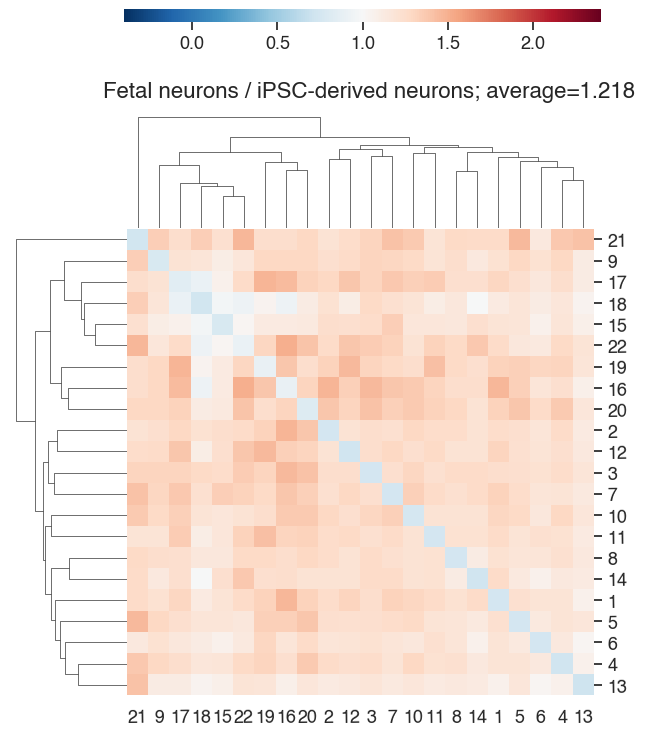

In [23]:
group1 = 'Fetal neurons'
group2 = 'iPSC-derived neurons'
name = f"{group1}_vs_{group2}"
savepath = f"./general_chromatin_analysis_visualizations/cis_to_trans_{name}.pdf"
plot_cis_to_trans(array_lists, group1, group2, vmax=2.4, savepath = savepath)

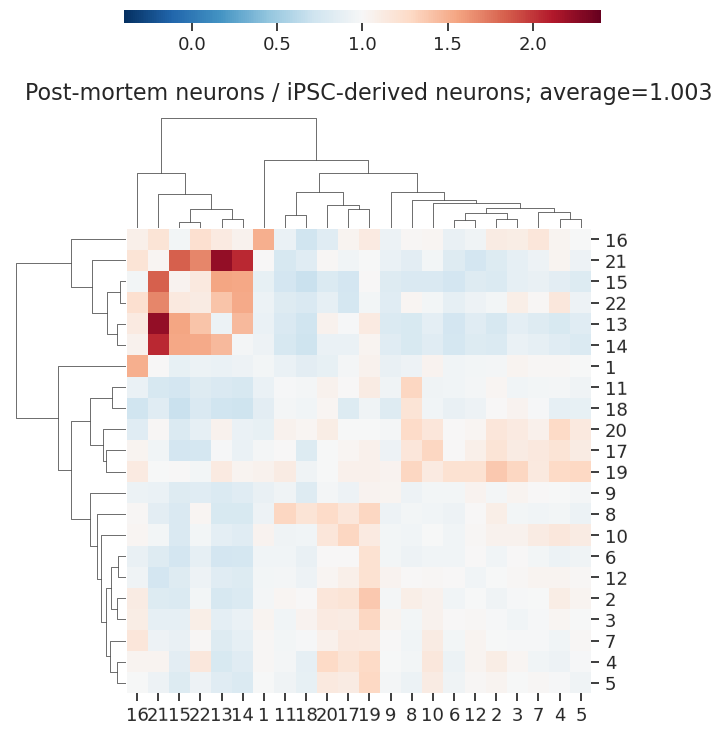

In [24]:
group1 = 'Post-mortem neurons'
group2 = 'iPSC-derived neurons'
name = f"{group1}_vs_{group2}"
savepath = f"./general_chromatin_analysis_visualizations/cis_to_trans_{name}.pdf"
plot_cis_to_trans(array_lists, group1, group2, vmax=2.4, savepath=savepath)

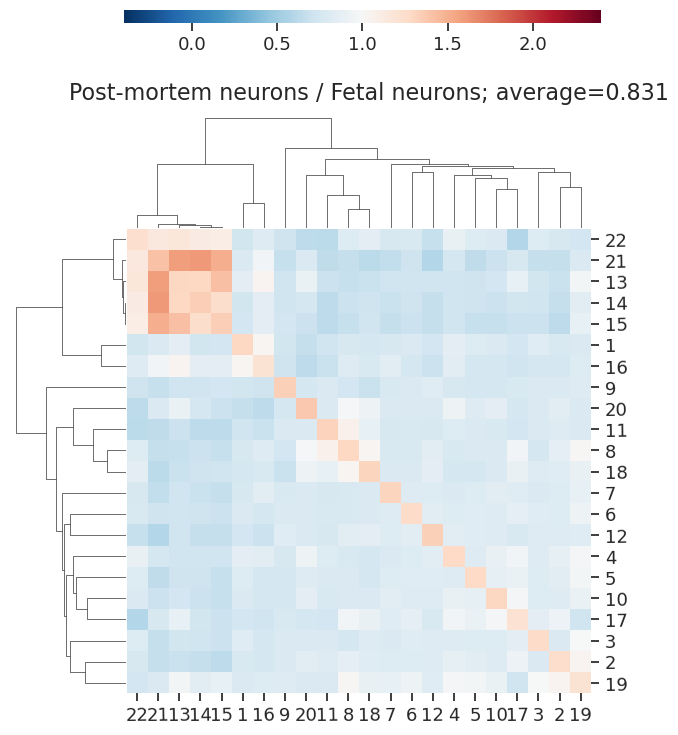

In [25]:
group1 = 'Post-mortem neurons'
group2 = 'Fetal neurons'
name = f"{group1}_vs_{group2}"
savepath = f"./general_chromatin_analysis_visualizations/cis_to_trans_{name}.pdf"

plot_cis_to_trans(array_lists, group1, group2, vmax=2.4, savepath=savepath)

## 3.2 Box plots

In [32]:
def get_matrix(group1 = 'Post-mortem neurons', group2 = 'iPSC-derived neurons'):    
    map1 = np.median(np.array(array_lists[group1]), axis=0 )
    map2 = np.median(np.array(array_lists[group2]), axis=0 )
    m = map1[:-3, :-3] / map2[:-3, :-3]
    return m

def get_matrix_elements(m):
    diagonal_elements = np.diag(m)
    upper_triangle_indices = np.triu_indices_from(m, k=1)
    upper_triangle_elements = m[upper_triangle_indices]
    return diagonal_elements, upper_triangle_elements

def get_df(pm_diagonal, pm_off_diagonal, cultures_diagonal, cultures_off_diagonal, columns = ['Post-mortem neurons', 'iPSC-derived neurons'] ):
    df_diagonal = pd.DataFrame(zip(pm_diagonal, cultures_diagonal), columns = columns)
    df_diagonal = pd.melt(df_diagonal,var_name='Group', value_name='Value')
    
    df_off_diagonal = pd.DataFrame(zip(pm_off_diagonal, cultures_off_diagonal), columns = columns)
    df_off_diagonal = pd.melt(df_off_diagonal,var_name='Group', value_name='Value')
    return df_diagonal, df_off_diagonal

def plot_dfs(df, ymin = 0.003, ymax = 0.015, group1 = 'Post-mortem neurons', group2 = 'iPSC-derived neurons', save_name = 'Post_mortem_neurons_vs_iPSC_derived_neurons_cis_contacts'):    
    plt.figure(figsize=(2, 3))
    palette = {'iPSC-derived neurons' : '#469433',
    'Stem-like cells' : 'dimgrey',
    'Fetal neurons' : '#9c2725',
    'Post-mortem neurons' : '#034e91',
    'Post-mortem non-neurons' : '#764e3f',
    'iPSC-derived glia' : '#ffa500',
    "Primary neurons":"#77658c"}
    data1 = df[df.Group == group1].Value.tolist()
    data2 = df[df.Group == group2].Value.tolist()

    statistic, p_value = wilcoxon(data1, data2)
    print(f"Wilcoxon signed-rank test statistic: {statistic}")
    print(f"P-value: {p_value}")    
    ax = sns.boxplot(x='Group', y='Value', width=0.4, data=df,
                     showmeans=True,
                     hue = 'Group',
                     # order = order,
                    boxprops=dict(linewidth=0.4),
                     whiskerprops=dict(linewidth=0.4),
                     capprops=dict(linewidth=0.4),
                     medianprops=dict(linewidth=0.4),
                     palette = palette,
                     meanprops={"marker": "o",
                                "markeredgecolor": "white",
                                "markerfacecolor": "white",
                                "markersize": "3"},
                     showfliers=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('Group')
    plt.ylabel('Contact frequency')
    plt.ylim(ymin, ymax)    
    plt.savefig(f"./general_chromatin_analysis_visualizations/{save_name}.pdf", bbox_inches='tight', format = "pdf")
    plt.show()

Wilcoxon signed-rank test statistic: 122.0
P-value: 0.898735523223877


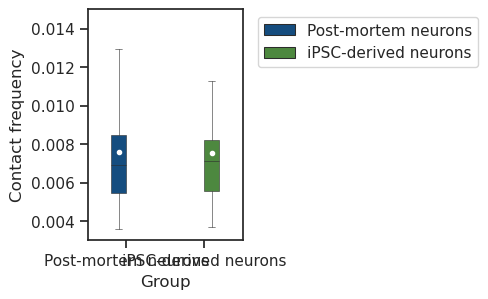

Wilcoxon signed-rank test statistic: 11450.0
P-value: 0.0553883521806191


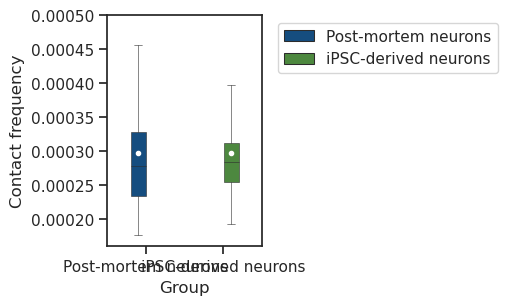

In [33]:
group1 = 'Post-mortem neurons'
group2 = 'iPSC-derived neurons'
map1 = np.median(np.array(array_lists[group1]), axis=0 )
map2 = np.median(np.array(array_lists[group2]), axis=0 )

pm_diagonal, pm_off_diagonal = get_matrix_elements(map1[:-3, :-3])
cultures_diagonal, cultures_off_diagonal = get_matrix_elements(map2[:-3, :-3])
df_diagonal, df_off_diagonal = get_df(pm_diagonal, pm_off_diagonal, cultures_diagonal, cultures_off_diagonal )

plot_dfs(df_diagonal, ymin = 0.003, ymax = 0.015, save_name = 'Post_mortem_neurons_vs_iPSC_derived_neurons_cis_contacts')

plot_dfs(df_off_diagonal, ymin = 0.00016, ymax = 0.0005, save_name = 'Post_mortem_neurons_vs_iPSC_derived_neurons_trans_contacts')


Wilcoxon signed-rank test statistic: 0.0
P-value: 4.76837158203125e-07


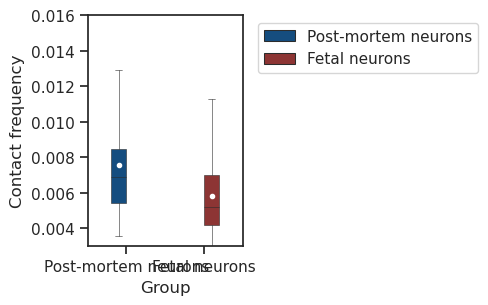

Wilcoxon signed-rank test statistic: 1362.0
P-value: 2.5081848918232665e-32


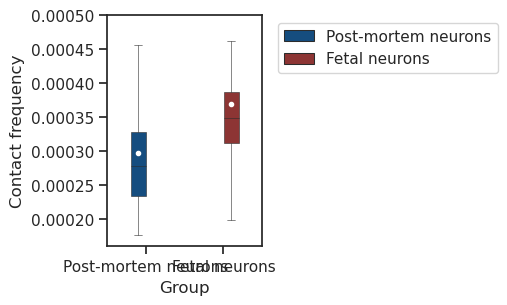

In [34]:
group1 = 'Post-mortem neurons'
group2 = 'Fetal neurons'
map1 = np.median(np.array(array_lists[group1]), axis=0 )
map2 = np.median(np.array(array_lists[group2]), axis=0 )
pm_diagonal, pm_off_diagonal = get_matrix_elements(map1[:-3, :-3])
fetal_diagonal, fetal_off_diagonal = get_matrix_elements(map2[:-3, :-3])
df_diagonal, df_off_diagonal = get_df(pm_diagonal, pm_off_diagonal, fetal_diagonal, fetal_off_diagonal, columns = ['Post-mortem neurons', 'Fetal neurons'] )

plot_dfs(df_diagonal, ymin = 0.003, ymax = 0.016, group1 = 'Post-mortem neurons', group2 = 'Fetal neurons',  save_name = 'Post_mortem_neurons_vs_Fetal_neurons_cis_contacts')

plot_dfs(df_off_diagonal, ymin = 0.00016, ymax = 0.0005, group1 = 'Post-mortem neurons', group2 = 'Fetal neurons',  save_name = 'Post_mortem_neurons_vs_Fetal_neurons_trans_contacts')


## 3.3. Study dynamics in Heffel et al. dataset

In [37]:
developing_early = [groups_results['Fetal neurons']['Heffel_2T.3056_cells.5kb.drop_diag.5kb.sampled_exact'],
                    groups_results['Fetal neurons']['Heffel_3T.3056_cells.5kb.drop_diag.5kb.sampled_exact']]

In [38]:
pairs = [('Heffel_3T.3056_cells.5kb.drop_diag.5kb.sampled_exact', 'Heffel_2T.3056_cells.5kb.drop_diag.5kb.sampled_exact'),
        ('Heffel_infant.3056_cells.5kb.drop_diag.5kb.sampled_exact', 'Heffel_3T.3056_cells.5kb.drop_diag.5kb.sampled_exact'),
         ('Heffel_adult.3056_cells.5kb.drop_diag.5kb.sampled_exact','Heffel_infant.3056_cells.5kb.drop_diag.5kb.sampled_exact')]

In [39]:
groups = [('Fetal neurons', 'Fetal neurons'),
        ('Fetal neurons', 'Fetal neurons'),
         ('Post-mortem neurons','Fetal neurons')]

Heffel_3T vs Heffel_2T


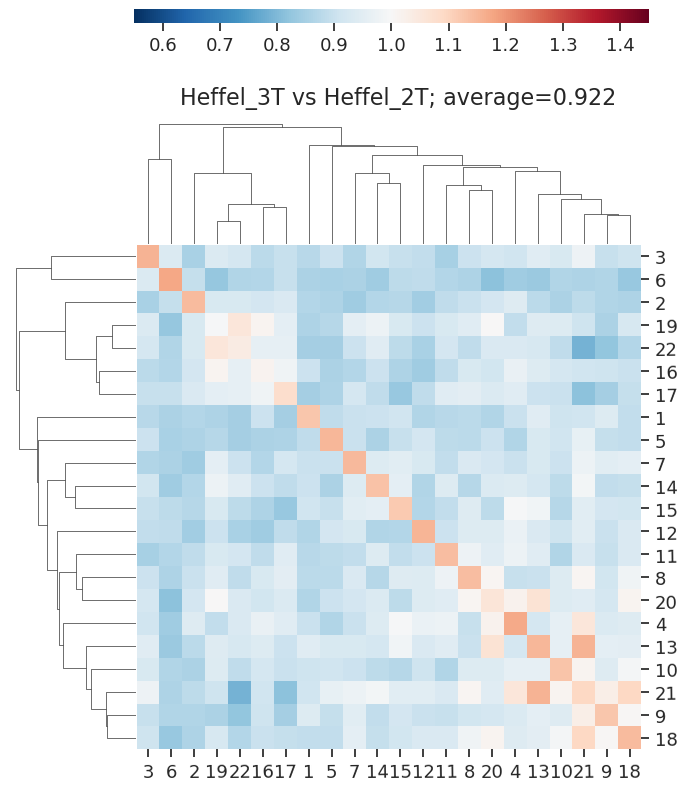

Heffel_infant vs Heffel_3T


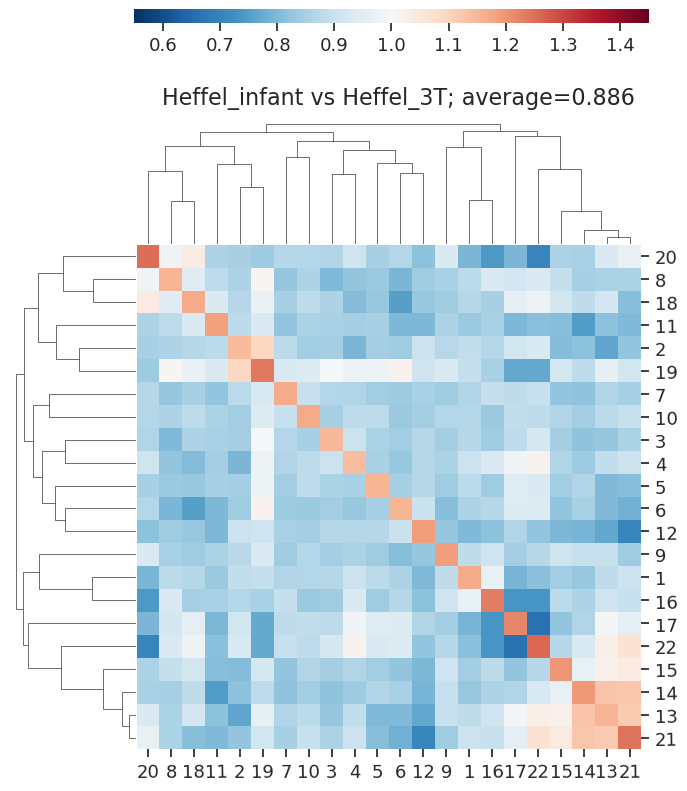

Heffel_adult vs Heffel_infant


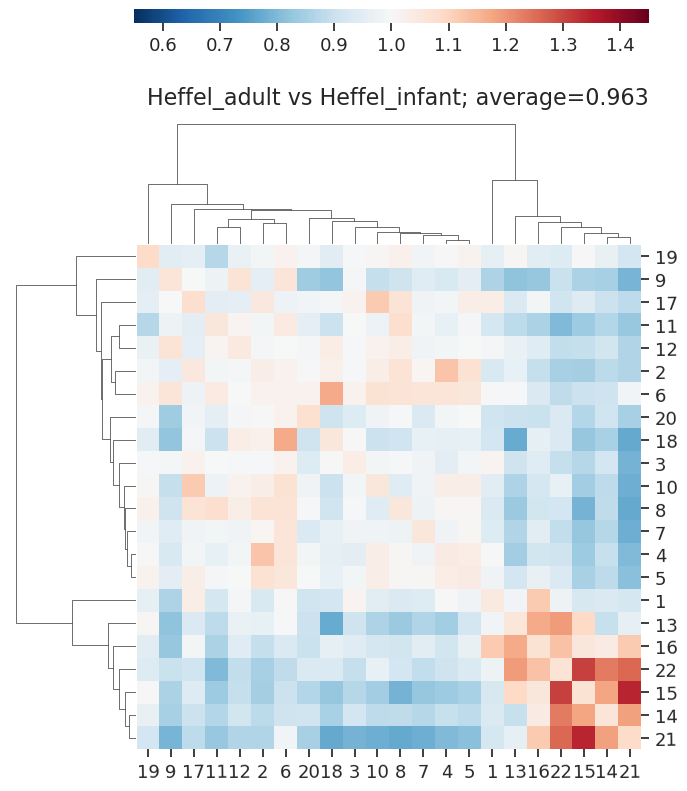

In [40]:
for group, pair in zip(groups, pairs):
    map1 = groups_results[group[0]][pair[0]]
    map2 = groups_results[group[1]][pair[1]]
    name = pair[0].split(".")[0] + " vs "+ pair[1].split(".")[0]
    print(name)
    savepath = f"./general_chromatin_analysis_visualizations/cis_to_trans_{name}.pdf"
    plot_cis_to_trans_any_maps(map1, map2, name, savepath=savepath)